In [37]:
import pandas as pd 
import sklearn as sk
import numpy as np
from sklearn import metrics as met
import seaborn as sns 
from matplotlib import pyplot
import random
import pandas_datareader as web
from pandas_datareader import data as pdr
import yfinance as yfin
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler



In [94]:
#Building compiling function 

def grabstocks():
    "grabs all stocks and puts them into dictionaries with their values"
    allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']
    
    #created stocktypes for testing reasons
    stocktypes = ['tech']
    # Initialize dict that will have all stocks and its type 
    
    stockdicts = {}
    fullstockdata = pd.DataFrame()
    
    for stocktype in allstocktypes:
        n = int(input("Enter number of "+str(stocktype)+" stocks(Type 0 for no stocks in sector): "))
        if n==0:
            pass
        else: 
            stockls = list(map(str,input("\nEnter "+str(stocktype)+" stock symbols separated by spaces: ").strip().split()))[:n]
            print(stockls)
            for stock in stockls:
                try: 
                    stockdata = pdr.get_data_yahoo(stock.upper(), start=datetime(2018,2,8), end=datetime(2022,3, 10))
                    stockdata['Stock Name'] = stock.upper()
                    stockdata['Stock Type'] = stocktype
                    fullstockdata = fullstockdata.append(stockdata)
                except:
                    print("Could not gather data on "+str(stock.upper()))
                    pass
    return(fullstockdata)

stocks=grabstocks()


Enter number of tech stocks(Type 0 for no stocks in sector): 10

Enter tech stock symbols separated by spaces: aapl msft goog amzn tsla fb pltr twtr orcl nvda
['aapl', 'msft', 'goog', 'amzn', 'tsla', 'fb', 'pltr', 'twtr', 'orcl', 'nvda']
Enter number of etf stocks(Type 0 for no stocks in sector): 10

Enter etf stock symbols separated by spaces: voo spy vde gld cibr ivv vcsh spdn fqal ftec
['voo', 'spy', 'vde', 'gld', 'cibr', 'ivv', 'vcsh', 'spdn', 'fqal', 'ftec']
Enter number of commodities stocks(Type 0 for no stocks in sector): 10

Enter commodities stock symbols separated by spaces: gold xon rio vale scco lyb btg eva bhp nem
['gold', 'xon', 'rio', 'vale', 'scco', 'lyb', 'btg', 'eva', 'bhp', 'nem']
Could not gather data on XON
Enter number of crypto stocks(Type 0 for no stocks in sector): 10

Enter crypto stock symbols separated by spaces: btc-usd eth-usd sol-usd matic-usd avax-usd link-usd doge-usd cro-usd atom-usd uni-usd
['btc-usd', 'eth-usd', 'sol-usd', 'matic-usd', 'avax-usd', '

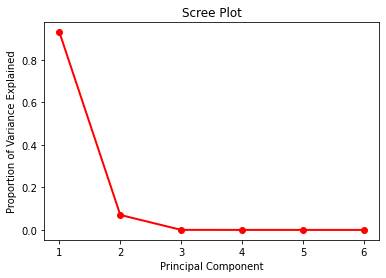

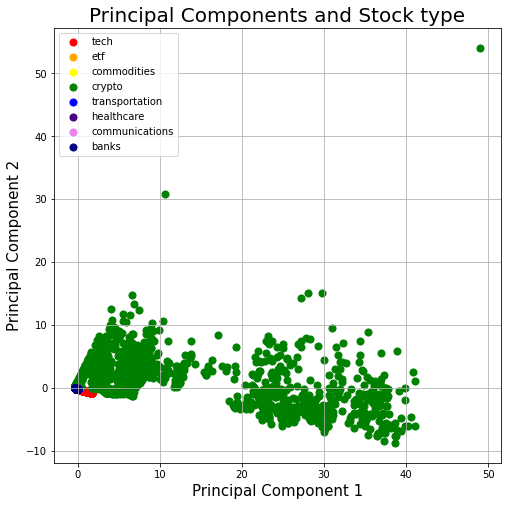

In [135]:
# Building PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# adjust features being used here. I used all features available initially
xvars = ['High','Low','Open','Close','Volume','Adj Close']
yvars=['Stock Type']

x = stocks.loc[:,xvars]
x = StandardScaler().fit_transform(x)

y = stocks.loc[:,yvars]

# Choose principal components that are responsile for at least 95% of the variance in the data
pca = PCA()
principalcomponents = pca.fit_transform(x)
# create pcs dataframe with all pcs and y variable(will reduce dimensionality of pcswithy later on)
pcs = pd.DataFrame(data = principalcomponents)

columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i+1))
pcs.columns = columnnames

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs, y], axis = 1)

#Screeplot of principal components

import matplotlib.pyplot as plt

pcvalues = np.arange(pca.n_components_) + 1
plt.plot(pcvalues, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

#Scatter plot of First 2 Principal components on stocktype

allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

#number_of_colors = len(allstocktypes)
#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color=['red','orange','yellow','green','blue','indigo','violet','navy']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Components and Stock type', fontsize = 20)

#Adjust x and y limits for better looking graph
#ax.set_xlim([-2.5, 10])
#ax.set_ylim([-2.5, 2.5])

for stocktype, color in zip(allstocktypes,color):
    indicesToKeep = pcswithy['Stock Type'] == stocktype
    ax.scatter(pcswithy.loc[indicesToKeep, 'Principal Component 1']
               , pcswithy.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(allstocktypes)
ax.grid()



In [136]:

"""Can use either of the following methods(or both):
1: Choose principal components responsible for at least 95% of variance in data
2. Find PCS that have eigenvalue greater than 1 and use those PCS"""


pcs = pd.DataFrame(data = principalcomponents)
columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i))
pcs.columns = columnnames


#Find principal components that have eigenvalue greater than 1. 

explained_var = {}
eigenvalues = list(pca.explained_variance_)
pcstokeep = []

for i in eigenvalues:
    if i<1:
        eigenvalues.remove(i)

for i,var in enumerate(eigenvalues):
    name = 'Principal Component '+str(i+1)
    explained_var.update({name:var})
    pcstokeep.append(name)
    
print(explained_var) 


# Add y value to principal component data frame 

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs[pcstokeep], y], axis = 1)

"""
Only the first Principal component has an eignvalue over 1(PC 2 has a very small eignevalue). Since I fit on all
the features as well as us having a lot of data there are probably some overfitting issues here. Play around with 
the features being used for the PCA. Will add a loading plot for better analysis. 

Also found that we can use the PCA to make our other models run quicker so we can probably use this PCA in a 
pipeline once we have decided on features to use. Here is a link for more info:

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
"""


{'Principal Component 1': 5.576502564057681, 'Principal Component 2': 0.0010765883303615177, 'Principal Component 3': 0.00010201864087352443}
       Principal Component 1  Principal Component 2  Principal Component 3  \
0                  -0.006517               0.000356               0.001031   
1                   0.005374               0.000035               0.001093   
2                  -0.002049              -0.000190               0.001098   
3                  -0.022670              -0.000057               0.001162   
4                  -0.016912              -0.000166               0.001182   
...                      ...                    ...                    ...   
78715              -0.053808               0.000866               0.001858   
78716              -0.052643               0.001273               0.001913   
78717              -0.052460               0.000038               0.002093   
78718              -0.053434              -0.000501               0.001745   
